# Evaluation script for Example 1: Burgers' equation

In [1]:
import sys
sys.path.append("../")
from libs import *
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Loading evaluation data
First we evaluate the Fourier Transformer for $n=2048$ case (`seq_len = 2048`).

In [8]:
subsample = 4
val_batch_size = 4
data_path = os.path.join(DATA_PATH, 'burgers_data_R10.mat')
valid_dataset = BurgersDataset(subsample=subsample,
                                train_data=False,
                                valid_portion=100,
                                data_path=data_path,)
valid_loader = DataLoader(valid_dataset, batch_size=val_batch_size, shuffle=False,
                              drop_last=False, pin_memory=True)

Loading burgers_data_R10.mat for valid.


## Loading models

In [4]:
with open(os.path.join(SRC_ROOT, 'config.yml')) as f:
    config = yaml.full_load(f)['ex1_burgers']
torch.cuda.empty_cache()
model = FourierTransformer(**config)
model = model.to(device)

# Evaluate the model
The error is approximately: 
$$\frac{1}{N}\sum_{i=1}^N \|T_{\theta}(u_0) - u(\cdot, t_1)\|_{L^2(\Omega)}$$

In [9]:
h = (1/2**13)*subsample
metric_func = WeightedL2Loss(regularizer=False, h=h)
model.load_state_dict(torch.load(os.path.join(MODEL_PATH, 'burgers_2048_4ft_96d_qkv_2021-05-26.pt')))
model.eval()
val_metric = validate_epoch_burgers(model, metric_func, valid_loader, device)
print(f"\nModel's validation metric: {list(val_metric.values())[0]:.3e}")


Model's validation metric: 1.123e-03


# Let us plot several solutions!

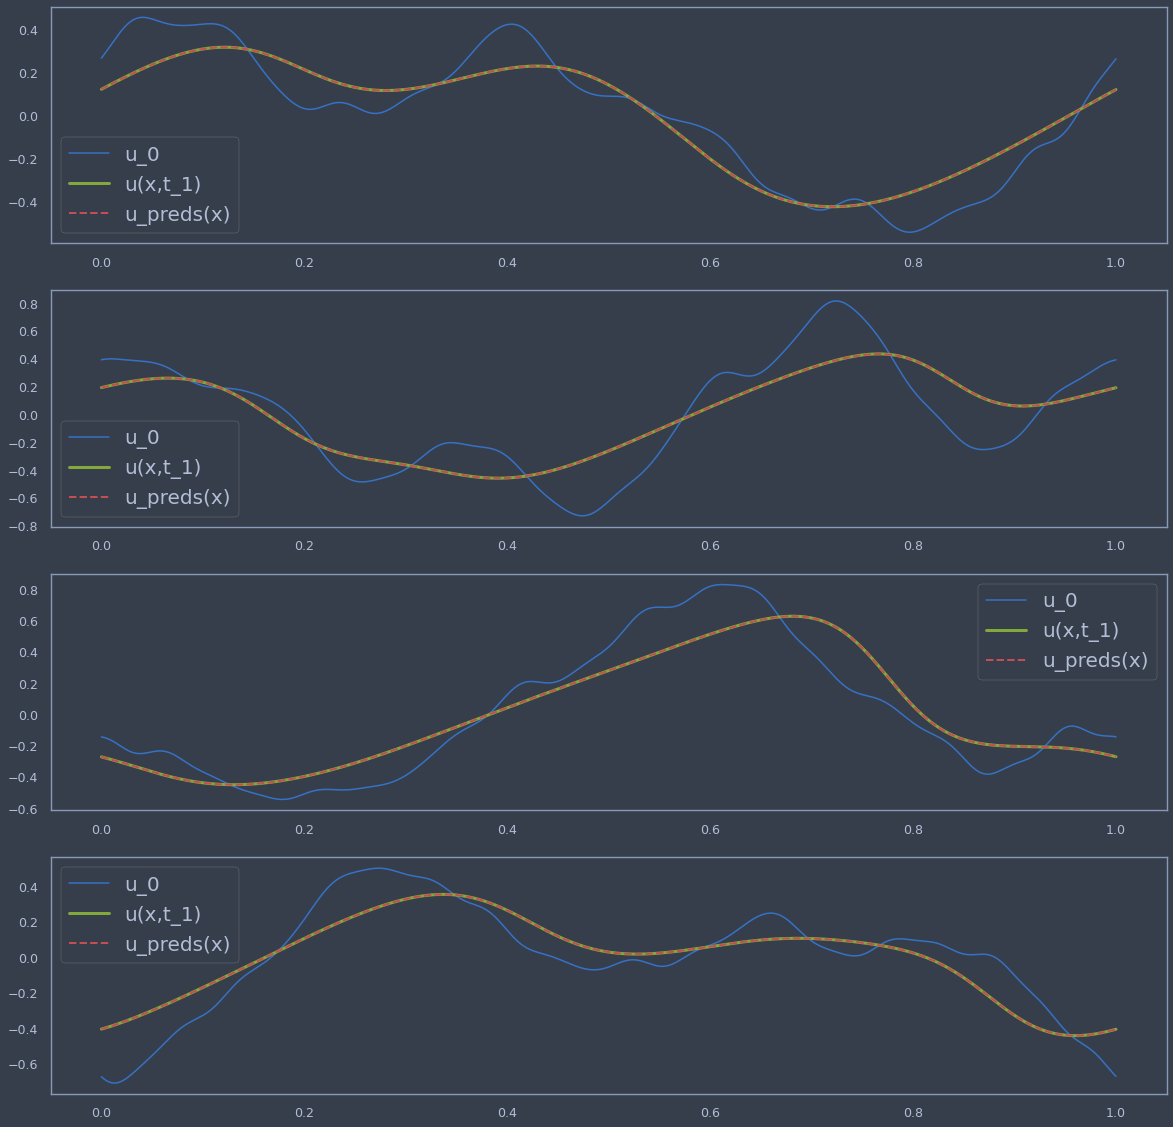

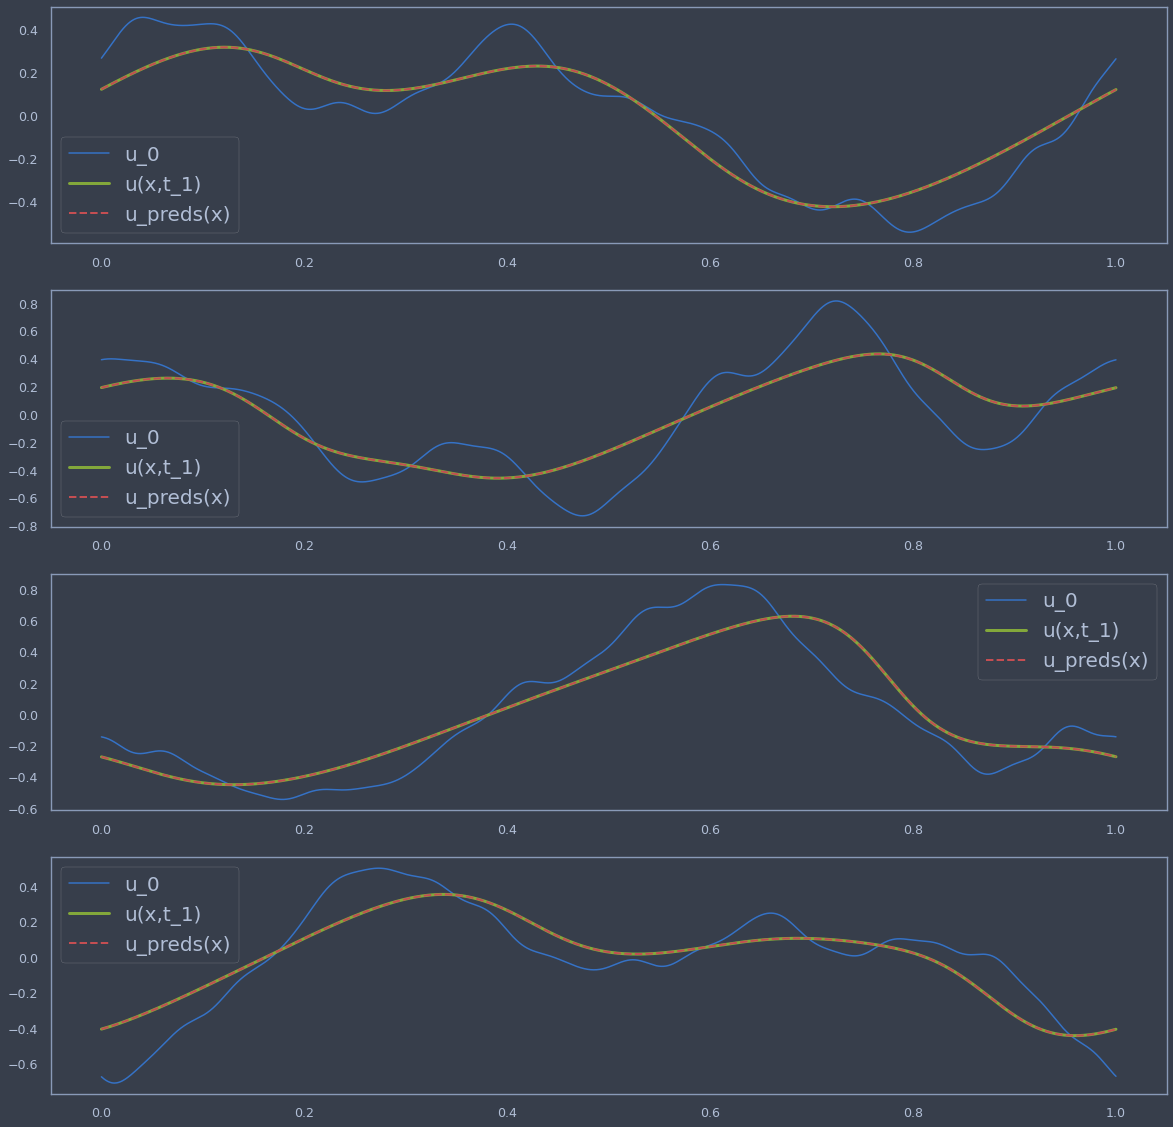

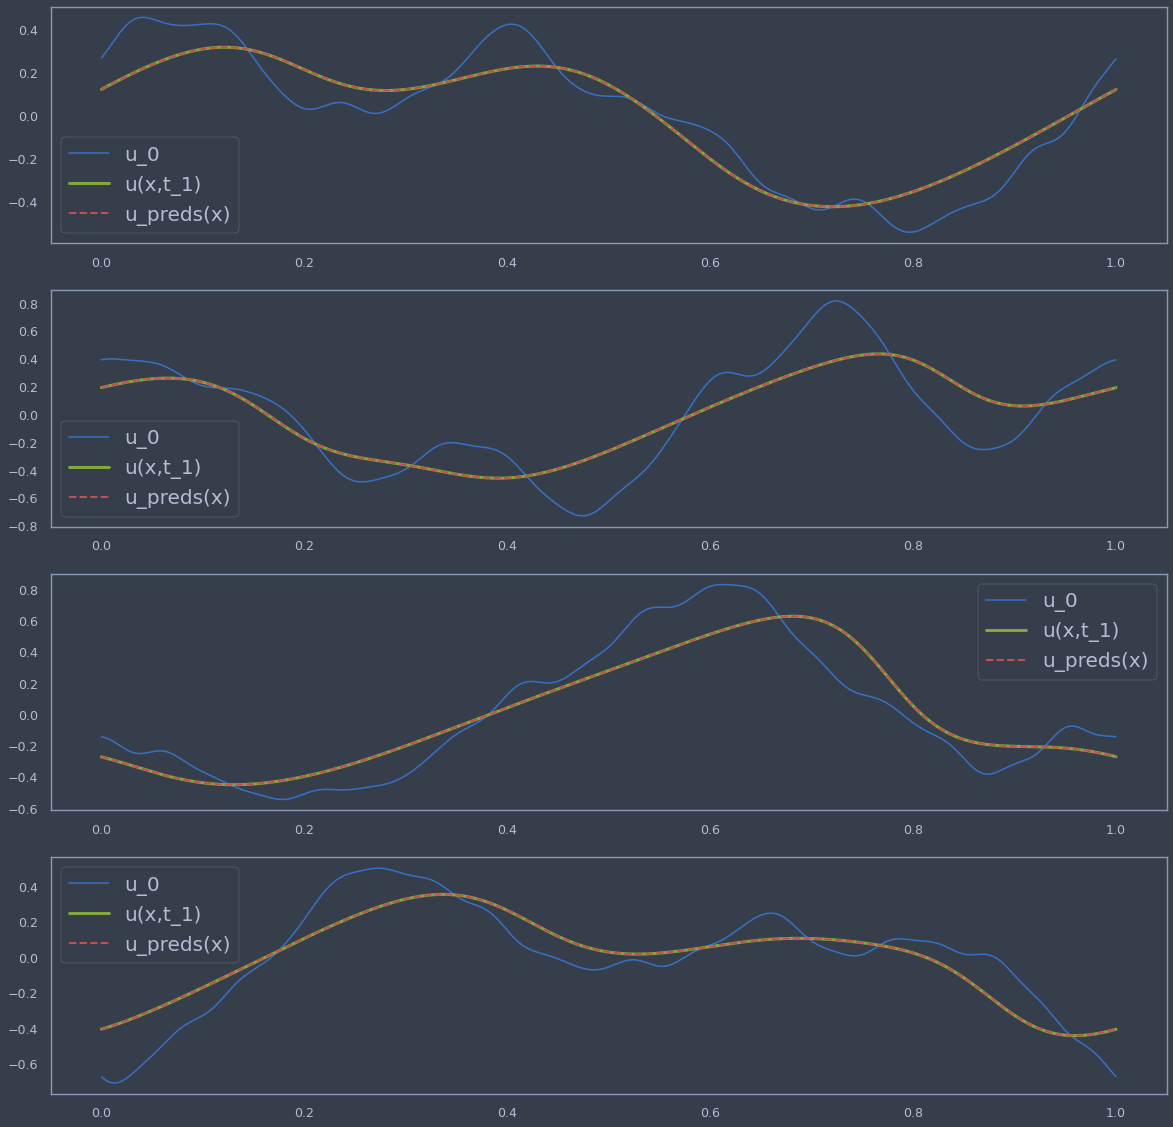

In [12]:
for _ in range(3):
    sample = next(iter(valid_loader))
    node = sample['node']
    pos = sample['pos']
    grid = sample['grid']
    u = sample['target']

    with torch.no_grad():
        model.eval()
        out_dict = model(node.to(device), 
                        None, pos.to(device), grid.to(device))

    out = out_dict['preds']
    preds = out[..., 0].detach().cpu()

    _, axes = plt.subplots(nrows=val_batch_size, ncols=1, figsize=(20, 5*val_batch_size))
    axes = axes.reshape(-1)
    for i in range(val_batch_size):
        grid = pos[i, :, 0]
        axes[i].plot(grid, node[i, :, 0], '-', color='b', linewidth=1.5, label='u_0')
        axes[i].plot(grid, u[i, :, 0], color='g', linewidth=3, label='u(x,t_1)')
        axes[i].plot(grid, preds[i, :], '--', color='r', linewidth=2, label='u_preds(x)')
        axes[i].legend(fontsize=20)
    plt.show()

# How about the Galerkin Transformer?

This time we do not do subsample: $n=8192$ (`seq_len = 8192`)

In [13]:
subsample = 1
val_batch_size = 4
data_path = os.path.join(DATA_PATH, 'burgers_data_R10.mat')
valid_dataset = BurgersDataset(subsample=subsample,
                                train_data=False,
                                valid_portion=100,
                                data_path=data_path,)
valid_loader = DataLoader(valid_dataset, batch_size=val_batch_size, shuffle=False,
                              drop_last=False, pin_memory=True)

Loading burgers_data_R10.mat for valid.


# Loading the model and compute the error on the validation set

In [14]:
with open(os.path.join(SRC_ROOT, 'config.yml')) as f:
    config = yaml.full_load(f)['ex1_burgers']
config['attention_type'] = 'galerkin'
torch.cuda.empty_cache()
model = FourierTransformer(**config)
model = model.to(device)

h = (1/2**13)*subsample
metric_func = WeightedL2Loss(regularizer=False, h=h)
model.load_state_dict(torch.load(os.path.join(MODEL_PATH, 'burgers_8192_4gt_96d_qkv_2021-05-22_paper.pt')))
model.eval()
val_metric = validate_epoch_burgers(model, metric_func, valid_loader, device)
print(f"\nModel's validation metric: {list(val_metric.values())[0]:.3e}")


Model's validation metric: 1.017e-03


# Let us plot some solutions!
Unfortunately the error is too small for human eyes to tell the difference with above...

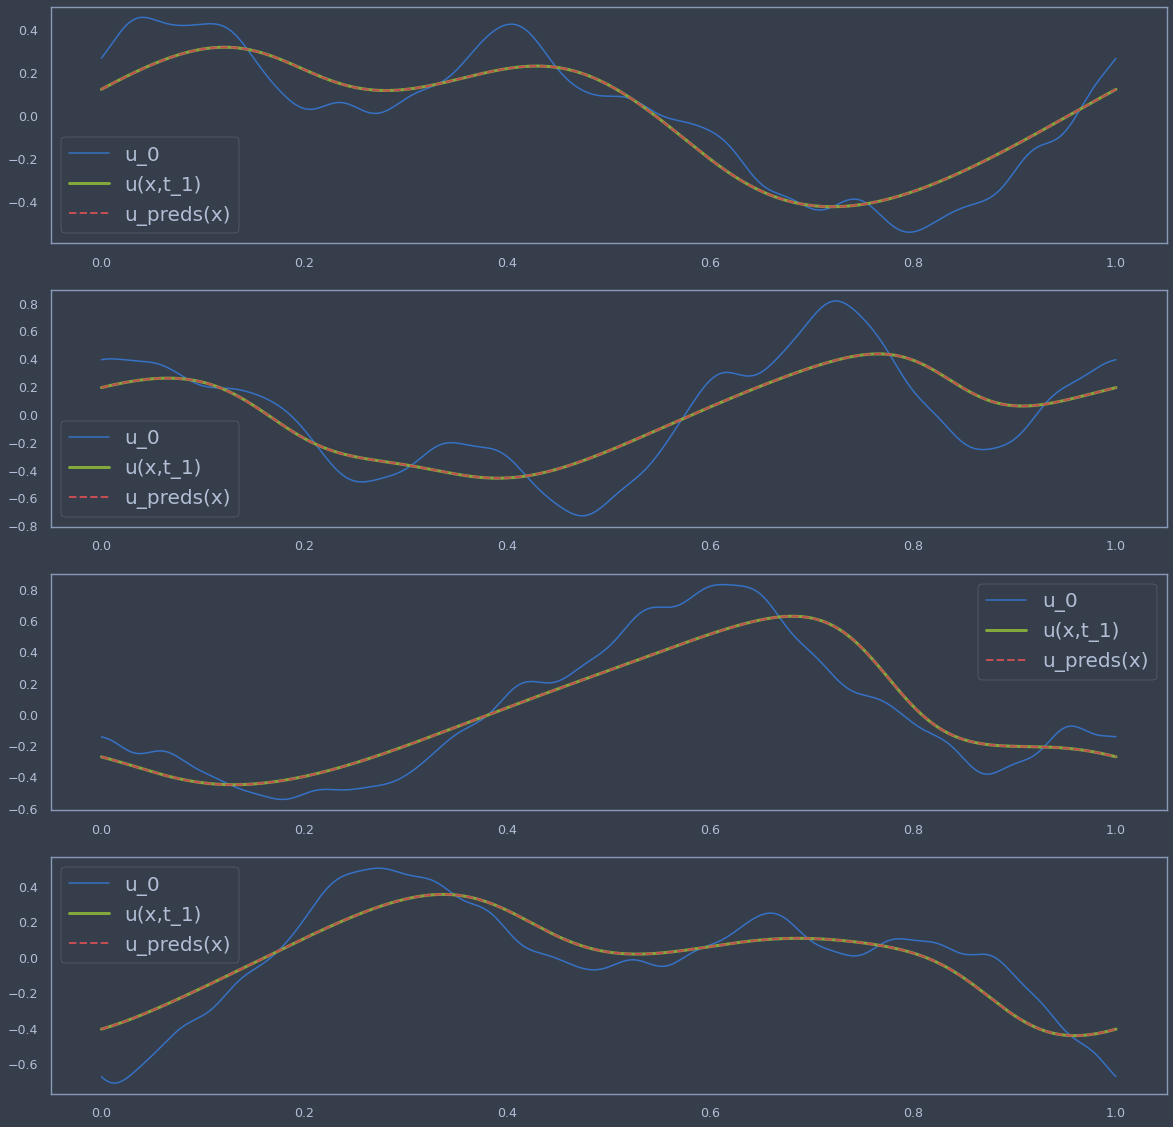

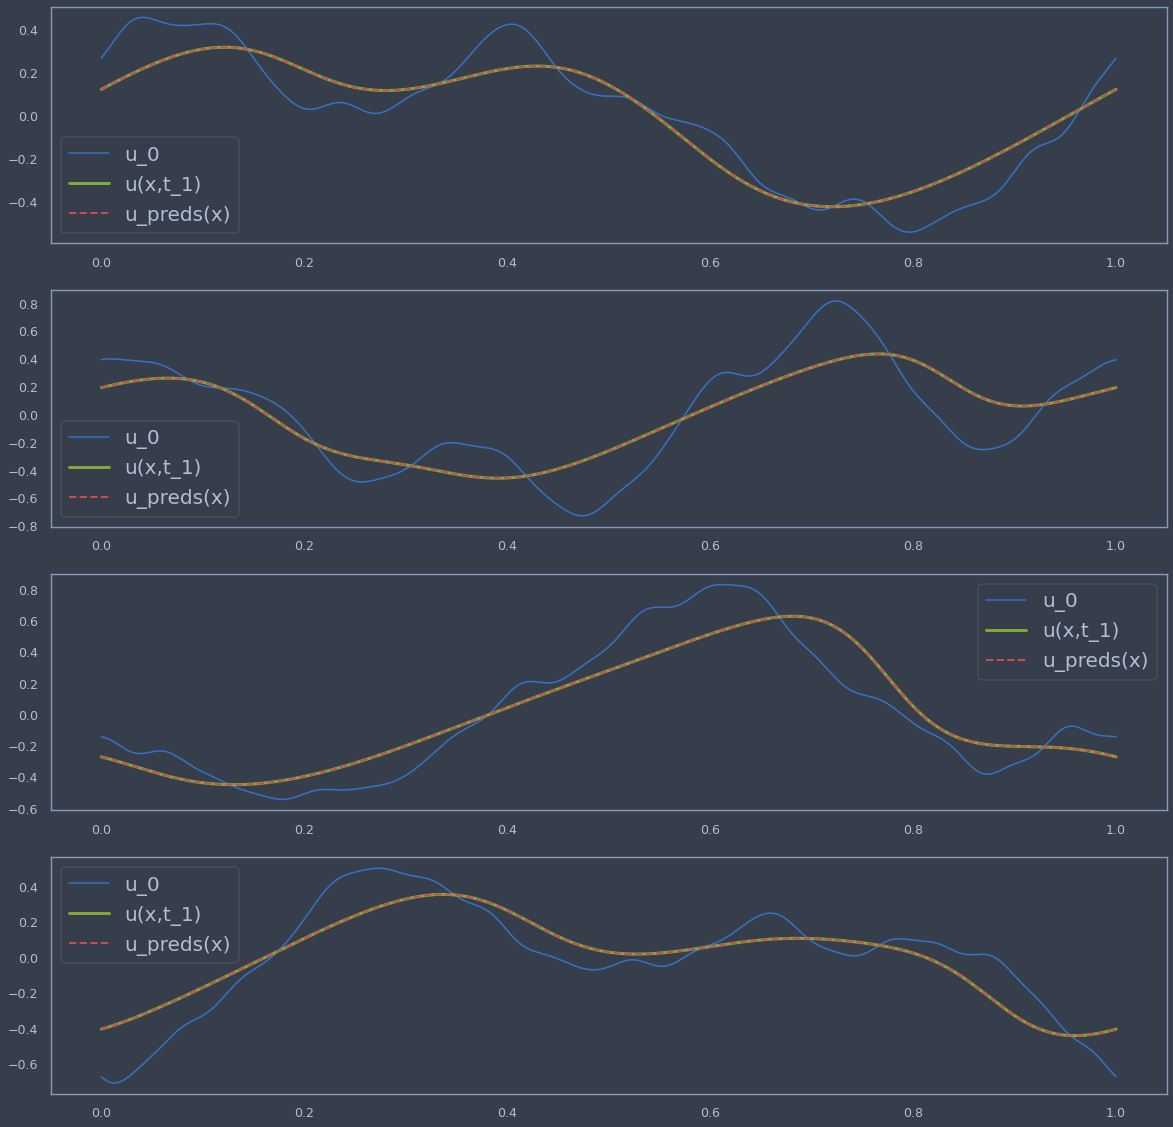

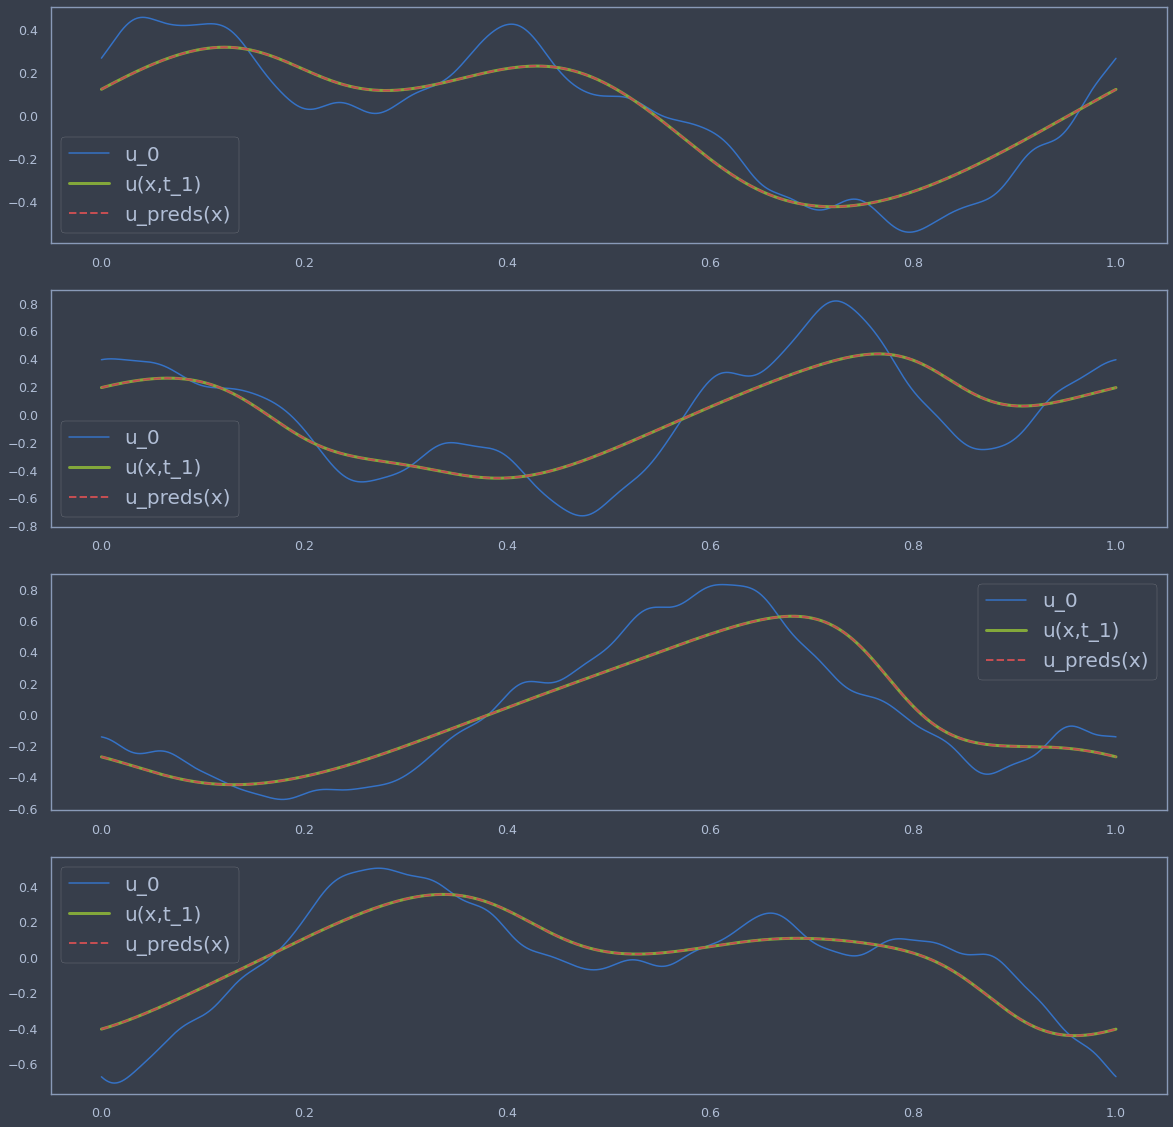

In [15]:
for _ in range(3):
    sample = next(iter(valid_loader))
    node = sample['node']
    pos = sample['pos']
    grid = sample['grid']
    u = sample['target']

    with torch.no_grad():
        model.eval()
        out_dict = model(node.to(device), 
                        None, pos.to(device), grid.to(device))

    out = out_dict['preds']
    preds = out[..., 0].detach().cpu()

    _, axes = plt.subplots(nrows=val_batch_size, ncols=1, figsize=(20, 5*val_batch_size))
    axes = axes.reshape(-1)
    for i in range(val_batch_size):
        grid = pos[i, :, 0]
        axes[i].plot(grid, node[i, :, 0], '-', color='b', linewidth=1.5, label='u_0')
        axes[i].plot(grid, u[i, :, 0], color='g', linewidth=3, label='u(x,t_1)')
        axes[i].plot(grid, preds[i, :], '--', color='r', linewidth=2, label='u_preds(x)')
        axes[i].legend(fontsize=20)
    plt.show()